In [49]:
%matplotlib inline

import material_interface as mi

ni_poscar = """Ni - primitive
1.0
   2.130422000	   0.000000000	   1.230000000
   0.710140800	   2.008582000	   1.230000000
   0.000000000	   0.000000000	   2.460000000
Ni
1
Selective dynamics
cartesian
   0.000000000    0.000000000    0.000000000 T T T Ni"""
au_poscar = """Au - primitive
1.0
   2.554775000	   0.000000000	   1.475000000
   0.851591600	   2.408665000	   1.475000000
   0.000000000	   0.000000000	   2.950000000
Au
1
Selective dynamics
cartesian
   0.000000000    0.000000000    0.000000000 T T T Au"""

graphene_poscar = """Graphene
1.0
   2.467291000	   0.000000000	   0.000000000
  -1.233645000	   2.136737000	   0.000000000
   0.000000000	   0.000000000	   7.803074000
C
2
direct
   0.000000000    0.000000000    0.000000000  C
   0.333333000    0.666667000    0.000000000  C
"""

from ase.build import surface, supercells
from ase.io import read, write
from ase.visualize import view
import io
import numpy as np


def func():
    ni = mi.poscar_to_atoms(ni_poscar)
    gr = mi.poscar_to_atoms(graphene_poscar)

    print(ni.get_cell())
    print(gr.get_cell())

    ni_surface = surface(ni, (1, 1, 0), layers=3)
    ni_surface.center(vacuum=10, axis=2)
    ni_surface.wrap()
    view(ni_surface * [3, 3, 1])

    gr.center(vacuum=10, axis=2)
    gr.wrap()
    view(gr)
    ni_slab = supercells.make_supercell(ni_surface, [[3, 0, 0], [0, 3, 0], [0, 0, 1]])
    ni_slab.center(vacuum=10, axis=2)
    ni_slab.wrap()

    view(ni_slab)

    print(mi.write_atoms_to_poscar(ni))


# func()

In [74]:
"""pymatgen"""
from pymatgen.analysis.interfaces.zsl import ZSLGenerator
from pymatgen.core.structure import Structure

# from pymatgen.analysis.interfaces.coherent_interfaces import CoherentInterfaceBuilder
from coherent_interface_builder import CoherentInterfaceBuilder

substrate = Structure.from_str(au_poscar, fmt="poscar")
layer = Structure.from_str(graphene_poscar, fmt="poscar")
substrate_miller = (1, 1, 1)
layer_miller = (0, 0, 1)

zsl = ZSLGenerator(max_area=700)
cib = CoherentInterfaceBuilder(
    substrate_structure=substrate,
    film_structure=layer,
    substrate_miller=substrate_miller,
    film_miller=layer_miller,
    zslgen=zsl,
)

cib._find_matches()
cib._find_terminations()
matches = cib.zsl_matches
terminations = cib.terminations
interfaces = list(cib.get_interfaces(terminations[0]))
print("Found {} matches".format(len(matches)))
print(f"TERMINATIONS: {len(terminations)}", terminations)
print(f"INTERFACES: {len(list(interfaces))}")

Found 2225 matches
TERMINATIONS: 1 [('C_P6/mmm_2', 'Au_R-3m_1')]
INTERFACES: 2225


In [75]:
from operator import itemgetter

interfaces_list = list(interfaces)

data = sorted(interfaces_list, key=itemgetter("von_mises_strain"))

# for i, object in enumerate(data):
#     print(i, "von Mises strain:", object["von_mises_strain"])
#     print(object["interface"])
#     print("film transform:\n", object["film_transform"])
#     print("substrate transform:\n", object["substrate_transform"])

{'interface': Structure Summary
Lattice
    abc : 8.850000152860169 8.850000170550283 22.0
 angles : 90.0 90.0 60.00000174185186
 volume : 1492.2441238577971
      A : 8.850000152860169 0.0 5.419062179826896e-16
      B : 4.424999852271613 7.664325105717805 5.419062190658967e-16
      C : 0.0 0.0 22.0
    pbc : True True True
PeriodicSite: Au (5.9, 6.813, 9.514) [0.2222, 0.8889, 0.4325]
PeriodicSite: Au (8.85, 6.813, 9.514) [0.5556, 0.8889, 0.4325]
PeriodicSite: Au (11.8, 6.813, 9.514) [0.8889, 0.8889, 0.4325]
PeriodicSite: Au (4.425, 4.258, 9.514) [0.2222, 0.5556, 0.4325]
PeriodicSite: Au (7.375, 4.258, 9.514) [0.5556, 0.5556, 0.4325]
PeriodicSite: Au (10.33, 4.258, 9.514) [0.8889, 0.5556, 0.4325]
PeriodicSite: Au (2.95, 1.703, 9.514) [0.2222, 0.2222, 0.4325]
PeriodicSite: Au (5.9, 1.703, 9.514) [0.5556, 0.2222, 0.4325]
PeriodicSite: Au (8.85, 1.703, 9.514) [0.8889, 0.2222, 0.4325]
PeriodicSite: C (6.467, 0.5896, 11.51) [0.6923, 0.07692, 0.5234]
PeriodicSite: C (8.169, 2.358, 11.51) [

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


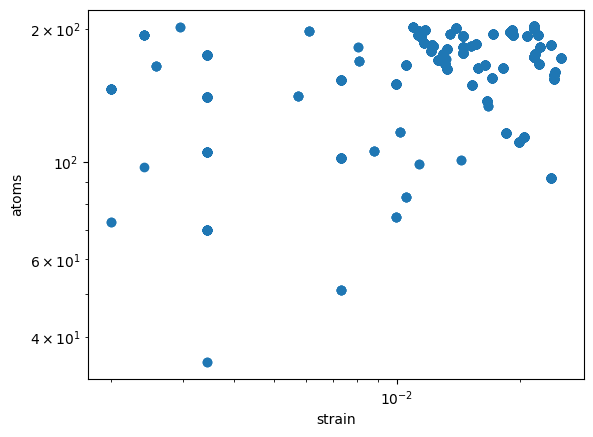

In [79]:
from ase.visualize import view
from pymatgen.analysis.interfaces import SubstrateMatch

print(interfaces_list[0])
i = interfaces_list[0]["interface"].to(fmt="poscar")
view(mi.poscar_to_atoms(i) * [3, 3, 1])

# map thru all interfaces and plot the strain vs number of atoms in the interface
strain = []
strain_von_mises = []
amount = []
print("lenght:", len(interfaces_list))
for i, object in enumerate(interfaces_list):
    strain.append(object["strain"])
    strain_von_mises.append(object["von_mises_strain"])
    amount.append(object["interface"].num_sites)

# plot the strain and strain_von_misses vs number of atoms in the interface with scatter plot
import matplotlib.pyplot as plt

plt.plot(strain_von_mises, amount, "o")
plt.xlabel("strain")
plt.ylabel("atoms")
plt.xscale("log")
plt.yscale("log")

plt.show()